# Training 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_core
import matplotlib.pyplot as plt

Using PyTorch backend.


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Using 656 files for training.
Using 655 files for validation.
Number of training samples: 179
Number of validation samples: 21
Number of testing samples: 21


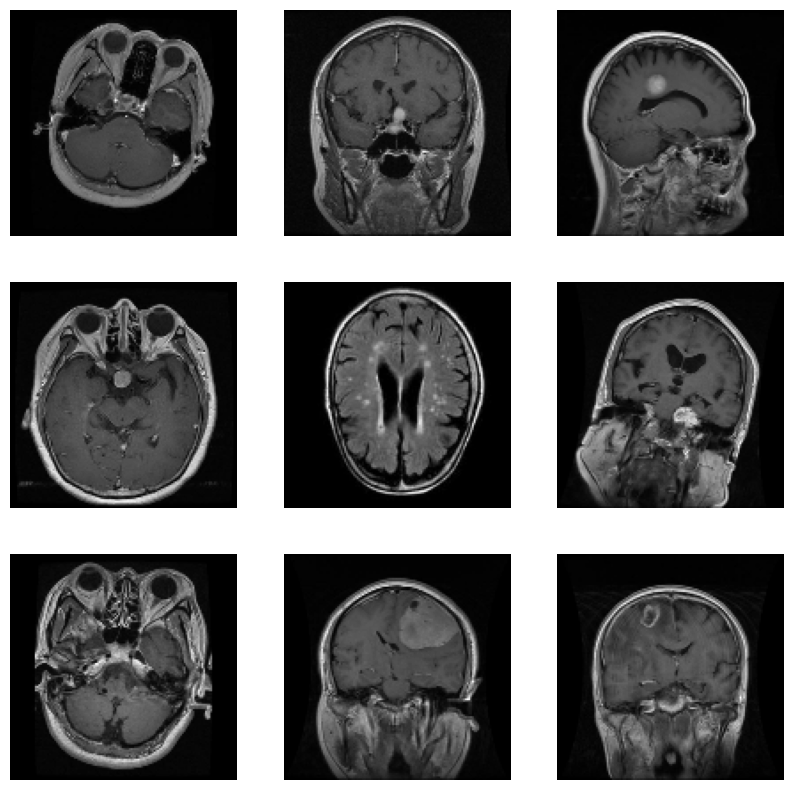

In [2]:
train_ds = keras_core.utils.image_dataset_from_directory(
    directory='dataset/training_data',
    labels='inferred',
    color_mode='grayscale',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128))


validation_ds, testing_ds = keras_core.utils.image_dataset_from_directory(
    directory='dataset/validation_data',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    validation_split=0.5,
    subset='both',
    seed=2,
    batch_size=32,
    image_size=(128, 128))


print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of testing samples: {testing_ds.cardinality()}")

# Take the first 9 images from the training dataset
images = train_ds.take(1)

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, image in enumerate(images):
    for x in range(9):
        axes[x].imshow(image[0][x].numpy().astype("uint8"), cmap='gray')
        axes[x].axis('off')
    
plt.show()

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
testing_ds = testing_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [3]:
data_augmentation = keras_core.Sequential(
    [
        keras_core.layers.RandomFlip(),
    ]
)

base_model = keras_core.applications.MobileNetV3Small(
    weights=None,  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 1),
    include_top=False, 
    include_preprocessing=False)  # Do not include the ImageNet classifier at the top.


# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras_core.Input(shape=(128, 128, 1))
x = data_augmentation(inputs)  # Apply random data augmentation

# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras_core.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras_core.layers.GlobalAveragePooling2D()(x)
x = keras_core.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras_core.layers.Dense(4, activation="sigmoid")(x)
model = keras_core.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ MobilenetV3small (Functional)   │ (None, 4, 4, 576)         │    938,832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 576)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 576)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 4)                 │      2,308 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 941,140 (3.59 MB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 938,832 (3.58 MB)

In [6]:
early_stop = keras_core.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, mode="min"
    )

model.compile(
    optimizer=keras_core.optimizers.Adam(),
    loss=keras_core.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - loss: 1.3861 - sparse_categorical_accuracy: 0.2809 - val_loss: 1.3856 - val_sparse_categorical_accuracy: 0.2881
Epoch 2/20
111/179 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - loss: 1.3855 - sparse_categorical_accuracy: 0.2835

KeyboardInterrupt: 